## Retrieval-Augmented Generation

In [6]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [7]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [8]:
pip install -qU "langchain[openai]"

Note: you may need to restart the kernel to use updated packages.


In [9]:
# get the chat model
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [10]:
# select embeddig model
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [11]:
pip install -qU langchain-core

Note: you may need to restart the kernel to use updated packages.


In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [14]:
#loading documents
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [16]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [17]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [18]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['07f8d7e7-4034-4b7f-ba80-4469f7ecbcf1', '5718aca7-8913-4697-a3ac-2e2ca5b7a7f2', 'cb1f1f8b-02f7-464e-a5ae-a099ab31c83e']


In [19]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

/Users/liliyalopez/opt/anaconda3/lib/python3.9/site-packages/langsmith/client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/Users/liliyalopez/opt/anaconda3/lib/python3.9/site-packages/langsmith/client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=5a250938-27fc-4f2c-be66-73d26009e6d6,id=5a250938-27fc-4f2c-be66-73d26009e6d6; trace=5a250938-27fc-4f2c-be66-73d26009e6d6,id=5a250938-27fc-4f2c-be66-73d26009e6d6


In [20]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [21]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [22]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

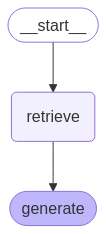

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=6ded7a2f-4dbc-45db-8953-e8c8b506d81d,id=6ded7a2f-4dbc-45db-8953-e8c8b506d81d; trace=6ded7a2f-4dbc-45db-8953-e8c8b506d81d,id=09e3aff5-4058-444d-9905-83997f88bd13; trace=6ded7a2f-4dbc-45db-8953-e8c8b506d81d,id=09e3aff5-4058-444d-9905-83997f88bd13; trace=6ded7a2f-4dbc-45db-8953-e8c8b506d81d,id=0e98cb89-9523-48e2-9885-cf48e4c3056f; trace=6ded7a2f-4dbc-45db-8953-e8c8b506d81d,id=0d023fad-8679-4a2c-adcb-791591622f63; trace=6ded7a2f-4dbc-45db-8953-e8c8b506d81d,id=0d023fad-8679-4a2c-adcb-791591622f63; trace=6ded7a2f-4dbc-45db-8953-e8c8b506d81d,id=894b5ae0-ccc6-4d2a-9db4-378cb8a59211


Context: [Document(id='cb1f1f8b-02f7-464e-a5ae-a099ab31c83e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='056fce4c-0a98-4dd3-82f1-ba86a9d432ee', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=6ded7a2f-4dbc-45db-8953-e8c8b506d81d,id=894b5ae0-ccc6-4d2a-9db4-378cb8a59211; trace=6ded7a2f-4dbc-45db-8953-e8c8b506d81d,id=0e98cb89-9523-48e2-9885-cf48e4c3056f; trace=6ded7a2f-4dbc-45db-8953-e8c8b506d81d,id=6ded7a2f-4dbc-45db-8953-e8c8b506d81d


In [28]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='cb1f1f8b-02f7-464e-a5ae-a099ab31c83e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='056fce4c-0a98-4dd3-82f1-ba86a9d432ee', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent sy

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=5a6c7130-985a-47bf-aac2-e85c13eff431,id=5a6c7130-985a-47bf-aac2-e85c13eff431; trace=5a6c7130-985a-47bf-aac2-e85c13eff431,id=1c1042ad-2950-41fa-9235-a90f242c689d; trace=5a6c7130-985a-47bf-aac2-e85c13eff431,id=1c1042ad-2950-41fa-9235-a90f242c689d; trace=5a6c7130-985a-47bf-aac2-e85c13eff431,id=d26dc79e-2d68-4aca-b538-db9b3553e770; trace=5a6c7130-985a-47bf-aac2-e85c13eff431,id=31d174a3-d85d-48b6-ad29-95a8f8a05f37; trace=5a6c7130-985a-47bf-aac2-e85c13eff431,id=31d174a3-d85d-48b6-ad29-95a8f8a05f37; trace=5a6c7130-985a-47bf-aac2-e85c13eff431,id=959d95e0-9234-4e8f-8508-90bdfb43911a


{'generate': {'answer': 'Task Decomposition is the process of breaking down a complex task into smaller, more manageable steps to simplify problem-solving. It often involves techniques such as Chain of Thought (CoT), where a model follows a step-by-step approach to enhance performance on challenging tasks. Additionally, it can be assisted by prompts, task-specific instructions, or human inputs to achieve the desired outcomes.'}}

----------------



Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=5a6c7130-985a-47bf-aac2-e85c13eff431,id=959d95e0-9234-4e8f-8508-90bdfb43911a; trace=5a6c7130-985a-47bf-aac2-e85c13eff431,id=d26dc79e-2d68-4aca-b538-db9b3553e770; trace=5a6c7130-985a-47bf-aac2-e85c13eff431,id=5a6c7130-985a-47bf-aac2-e85c13eff431


In [29]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=b7e556b7-ee28-464d-9906-765aa04c1382,id=b7e556b7-ee28-464d-9906-765aa04c1382; trace=b7e556b7-ee28-464d-9906-765aa04c1382,id=11737a9e-b871-4170-aaa6-cbf825d0359a


|Task| De|composition| is| the| process| of| breaking| down| a| complex| task| into| smaller|,| manageable| steps|,| allowing| for| easier| planning| and| execution|

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=b7e556b7-ee28-464d-9906-765aa04c1382,id=11737a9e-b871-4170-aaa6-cbf825d0359a; trace=b7e556b7-ee28-464d-9906-765aa04c1382,id=42836092-91b8-4cc8-a9c7-8cfd08ecc104; trace=b7e556b7-ee28-464d-9906-765aa04c1382,id=b7565c81-f863-4a3e-8525-42ab7eef866e; trace=b7e556b7-ee28-464d-9906-765aa04c1382,id=b7565c81-f863-4a3e-8525-42ab7eef866e; trace=b7e556b7-ee28-464d-9906-765aa04c1382,id=5988c87b-7c34-4b9a-b939-814b5b8f6a9a


.| It| often| utilizes| techniques| like| Chain| of| Thought| (|Co|T|)| to| guide| models| in| thinking| step|-by|-step|,| which| improves| their| performance| on| challenging| tasks|.| This| can| be| achieved| through| simple| prompting|,| task|-specific| instructions|,| or| human| inputs|.||

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=b7e556b7-ee28-464d-9906-765aa04c1382,id=5988c87b-7c34-4b9a-b939-814b5b8f6a9a; trace=b7e556b7-ee28-464d-9906-765aa04c1382,id=42836092-91b8-4cc8-a9c7-8cfd08ecc104; trace=b7e556b7-ee28-464d-9906-765aa04c1382,id=b7e556b7-ee28-464d-9906-765aa04c1382


In [30]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)